In [ ]:
#ライブラリのインポート
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [ ]:
#データの読み込み・表示
train = pd.read_csv('train.tsv',sep='\t')
test  = pd.read_csv('test.tsv',sep='\t')
train.head()

,id,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


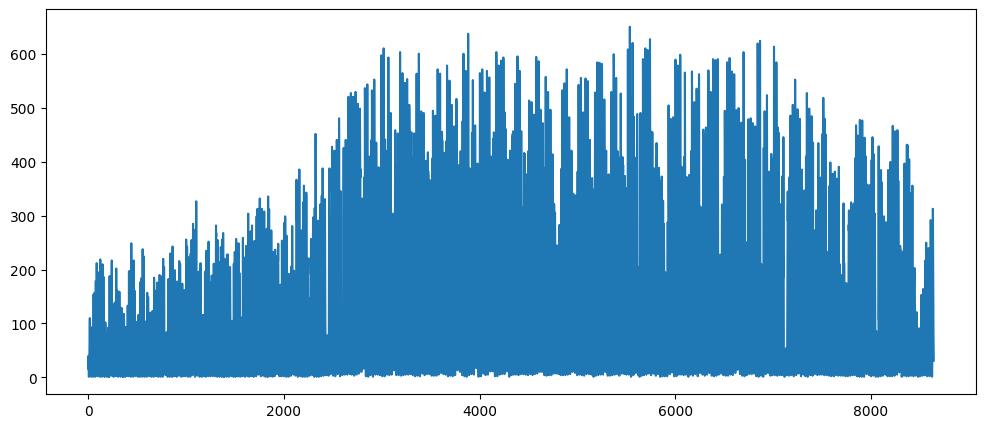

In [ ]:
#利用状況のプロット
plt.figure(figsize=(12,5))
plt.plot(train['id'],train['cnt'])

In [ ]:
#XGBoostモデルの作成
reg = xgb.XGBRegressor()

In [ ]:
#傾向が異なる部分をカット
train = train[train['id'] > 2500]
train = train[train['id'] < 8500]

In [ ]:
#必要なデータを格納
X_train = train.drop(['id','dteday','cnt'], axis=1)
y_train = train['cnt']
X_test = test.drop(['id','dteday'], axis=1)

In [ ]:
X_train.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
2500,2,0,4,2,0,2,1,1,0.46,0.4545,0.67,0.2836
2501,2,0,4,3,0,2,1,1,0.48,0.4697,0.63,0.2239
2502,2,0,4,4,0,2,1,1,0.46,0.4545,0.67,0.0896
2503,2,0,4,5,0,2,1,2,0.46,0.4545,0.72,0.1940
2504,2,0,4,6,0,2,1,2,0.48,0.4697,0.67,0.0000


In [ ]:
y_train.head()

2500    13
2501     3
2502     5
2503    18
2504    65
Name: cnt, dtype: int64

In [ ]:
X_test.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,1,1,1,0,0,0,0,1,0.36,0.3788,0.66,0.0000
1,1,1,1,1,0,0,0,1,0.36,0.3485,0.66,0.1343
2,1,1,1,2,0,0,0,1,0.32,0.3485,0.76,0.0000
3,1,1,1,3,0,0,0,1,0.30,0.3333,0.81,0.0000
4,1,1,1,4,0,0,0,1,0.28,0.3030,0.81,0.0896


In [ ]:
#最適な深度と決定木のパラメータを探索する。
reg_cv = GridSearchCV(reg, {'max_depth': [2,4,6], 'n_estimators': [50,100,200]}, verbose=1)
reg_cv.fit(X_train, y_train)
print(reg_cv.best_params_, reg_cv.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
{'max_depth': 4, 'n_estimators': 100} 0.8866447045005016


In [ ]:
#最適なパラメーターでの学習
reg = xgb.XGBRegressor(**reg_cv.best_params_)
reg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [ ]:
#学習データwp使って予測する。
pred_train = reg.predict(X_train)

<Axes: >

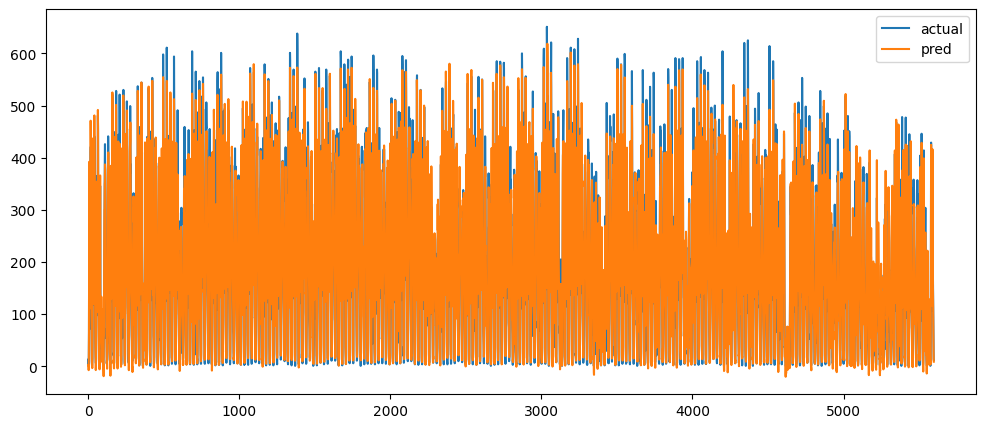

In [ ]:
#予測値の確認
train_value = y_train.values
_df = pd.DataFrame({'actual':train_value,'pred':pred_train})
_df.plot(figsize=(12,5))

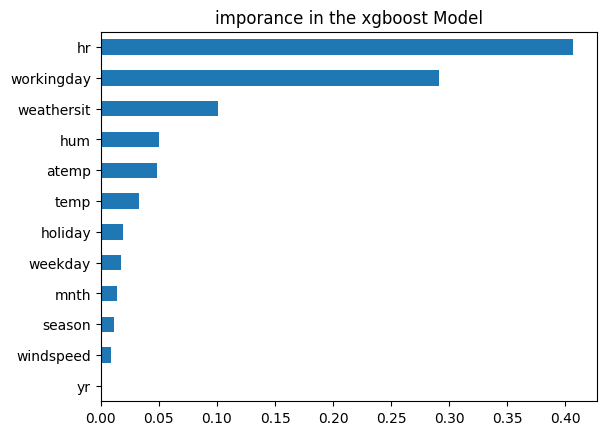

In [ ]:
#評特微量の重要度の確認をプロット
importances = pd.Series(reg.feature_importances_, index = X_train.columns)
importances = importances.sort_values()
importances.plot(kind = "barh")
plt.title("imporance in the xgboost Model")
plt.show()

In [ ]:
#テストデータに対しての予測値の算出
pred_test = reg.predict(X_test)

In [ ]:
#結果の貼り付けとファイルの出力
sample = pd.read_csv("sample_submit.csv",header=None)
sample[1] = pred_test
sample.to_csv("submit04.csv",index=None,header=None)